In [0]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops


%matplotlib inline
np.random.seed(1)

In [24]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import sys
sys.path.insert(0, '/content/gdrive/My Drive/Colab Notebooks')

In [0]:
from cnn_utils import *

In [0]:
def load_dataset():
    train_dataset = h5py.File('/content/gdrive/My Drive/Colab Notebooks/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('/content/gdrive/My Drive/Colab Notebooks/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 2


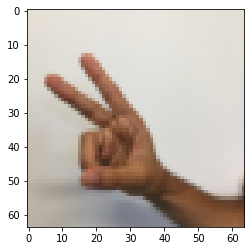

In [28]:
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

y = 4


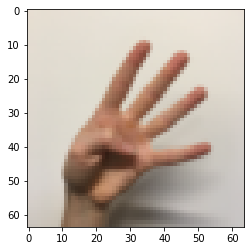

In [29]:
index = 60
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [30]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [0]:
#Here we have a function that creates the placeholders
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(dtype=tf.float32,shape=(None,n_H0,n_W0,n_C0)) #In both cases we put none in the first dimension, because we don't want to restric the batch size
    Y = tf.placeholder(dtype=tf.float32,shape=(None,n_y))   
    return X, Y 

In [32]:
X, Y = create_placeholders(64, 64, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


In [0]:
def initialize_parameters():
    tf.set_random_seed(1)
    W1 = tf.get_variable("W1",[4,4,3,8],initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2",[2,2,8,16],initializer=tf.contrib.layers.xavier_initializer(seed = 0))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [34]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1[1,1,1] = \n" + str(parameters["W1"].eval()[1,1,1]))
    print("W1.shape: " + str(parameters["W1"].shape))
    print("\n")
    print("W2[1,1,1] = \n" + str(parameters["W2"].eval()[1,1,1]))
    print("W2.shape: " + str(parameters["W2"].shape))

W1[1,1,1] = 
[ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W1.shape: (4, 4, 3, 8)


W2[1,1,1] = 
[-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]
W2.shape: (2, 2, 8, 16)


In [0]:

def forward_propagation(X, parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    Z1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding='SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1,ksize=[1,8,8,1],strides=[1,8,8,1],padding='SAME')
    Z2 = tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding='SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2,ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME')
    F = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(F,num_outputs=6,activation_fn=None)

    return Z3

In [42]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("Z3 = \n" + str(a))

Z3 = 
[[ 1.4416982  -0.24909668  5.4504995  -0.2618962  -0.20669872  1.3654671 ]
 [ 1.4070847  -0.02573182  5.08928    -0.4866991  -0.4094069   1.2624853 ]]


In [0]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.compat.v1.nn.softmax_cross_entropy_with_logits_v2(logits = Z3, labels = Y))
    return cost

In [46]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,64,64,3), Y: np.random.randn(4,6)})
    print("cost = " + str(a))

cost = 4.6648703


In [0]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001,
          num_epochs = 250, minibatch_size = 64, print_cost = True):
    
    ops.reset_default_graph()                       
    tf.set_random_seed(1)                            
    seed = 3                                         
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        
    
 
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    
    parameters = initialize_parameters()
   
    Z3 = forward_propagation(X, parameters)

    cost = compute_cost(Z3, Y)
   
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

    init = tf.global_variables_initializer()
     

    with tf.Session() as sess:
    
        sess.run(init)
        
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
               
                _ , temp_cost = sess.run(fetches = [optimizer, cost], feed_dict = {X: minibatch_X, Y: minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 1.971088
Cost after epoch 5: 1.894530
Cost after epoch 10: 1.881363
Cost after epoch 15: 1.853428
Cost after epoch 20: 1.772635
Cost after epoch 25: 1.606353
Cost after epoch 30: 1.370370
Cost after epoch 35: 1.155044
Cost after epoch 40: 1.029865
Cost after epoch 45: 0.913386
Cost after epoch 50: 0.841280
Cost after epoch 55: 0.761468
Cost after epoch 60: 0.705904
Cost after epoch 65: 0.638867
Cost after epoch 70: 0.612169
Cost after epoch 75: 0.575279
Cost after epoch 80: 0.541369
Cost after epoch 85: 0.509267
Cost after epoch 90: 0.476631
Cost after epoch 95: 0.459109
Cost after epoch 100: 0.456088
Cost after epoch 105: 0.408676
Cost after epoch 110: 0.393056
Cost after epoch 115: 0.379420
Cost after epoch 120: 0.401228
Cost after epoch 125: 0.391376
Cost after epoch 130: 0.363569
Cost after epoch 135: 0.342228
Cost after epoch 140: 0.326070
Cost after epoch 145: 0.313502
Cost after epoch 150: 0.312285
Cost after epoch 155: 0.297824
Cost after epoch 160: 0.286804

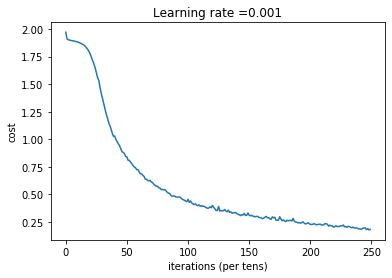

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.95185184
Test Accuracy: 0.875


In [54]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)